This First section is where we are importing the deep learning model

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import winsound
import csv

##from testCases_v4a import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


################################

def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy

    Arguments:
    Z -- numpy array of any shape

    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """

    A = 1 / (1 + np.exp(-Z))
    cache = Z

    return A, cache


def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """

    A = np.maximum(0, Z)

    assert (A.shape == Z.shape)

    cache = Z
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    Z = cache
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well.
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ


def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    Z = cache

    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)

    assert (dZ.shape == Z.shape)

    return dZ


#############################################################


def flatten_x(train_x, test_x, standardisation_const):
    # Reshape the training and test examples
    train_x_flatten = train_x.reshape(train_x.shape[0], -1).T  # The "-1" makes reshape flatten the remaining dimensions
    test_x_flatten = test_x.reshape(test_x.shape[0], -1).T

    # Standardize data to have feature values between 0 and 1.
    # For example for images magnitude of color is 255
    train_x = train_x_flatten / standardisation_const
    test_x = test_x_flatten / standardisation_const
    return train_x, test_x


def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network

    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)  # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters


def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """

    Z = np.dot(W, A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """

    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        z, linear_cache = linear_forward(A_prev, W, b)
        a, activation_cache = sigmoid(z)

    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        z, linear_cache = linear_forward(A_prev, W, b)
        a, activation_cache = relu(z)

    assert (a.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return a, cache


def L_model_forward(x, parameters, outputs):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation

    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()

    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    a = x
    L = len(parameters) // 2  # number of layers in the neural network

    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        a_prev = a
        a, cache = linear_activation_forward(a_prev, parameters['W' + str(l)], parameters['b' + str(l)],
                                             activation='relu')
        caches.append(cache)

    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    al, cache = linear_activation_forward(a, parameters['W' + str(L)], parameters['b' + str(L)], activation='sigmoid')
    caches.append(cache)

    assert (al.shape == (outputs, x.shape[1]))

    return al, caches


def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = -1 / m * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))

    cost = np.squeeze(cost)  # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert (cost.shape == ())

    return cost


def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1 / m * np.dot(dZ, A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.

    Arguments:
    dA -- post-activation gradient for current layer l
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group

    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])

    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ...
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ...
    """
    grads = {}
    L = len(caches)  # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # after this line, Y is the same shape as AL

    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L - 1]
    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,
                                                                                                      current_cache,
                                                                                                      activation="sigmoid")

    # Loop from l=L-2 to l=0
    for l in reversed(range(L - 1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)]
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache,
                                                                    activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent

    Arguments:
    parameters -- python dictionary containing your parameters
    grads -- python dictionary containing your gradients, output of L_model_backward

    Returns:
    parameters -- python dictionary containing your updated parameters
                  parameters["W" + str(l)] = ...
                  parameters["b" + str(l)] = ...
    """

    L = len(parameters) // 2  # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l + 1)] -= learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] -= learning_rate * grads["db" + str(l + 1)]
    return parameters


def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):  # lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.

    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []  # keep track of cost

    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters, layers_dims[-1])

        # Compute cost.
        cost = compute_cost(AL, Y)

        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

This second section is for the setup of the file import and the formating of the data from PycharmProject/DeepLearningTesting/data

In [3]:
image_shape = [28, 28]
outputs = 10
image_pixels = image_shape[0] * image_shape[1]

# Import data and format
st = time.time()
train_data = np.loadtxt("PycharmProject/DeepLearningTesting/data/mnist_train.csv", delimiter=",")
test_data = np.loadtxt("PycharmProject/DeepLearningTesting/data/mnist_test.csv", delimiter=",")
print("Time taken: " + str(time.time() - st))
train_labels = np.reshape([i[0] for i in train_data], (60000, 1))
test_labels = np.reshape([i[0] for i in test_data], (10000, 1))

train_labels = np.c_[train_labels, np.zeros((train_labels.shape[0], outputs - train_labels.shape[1]))]
test_labels = np.c_[test_labels, np.zeros((test_labels.shape[0], outputs - test_labels.shape[1]))]

for i in range(0, train_labels.shape[0]):
    x = train_labels[i][0]
    train_labels[i][0] = 0
    train_labels[i][int(x)] = 1
for i in range(0, test_labels.shape[0]):
    x = test_labels[i][0]
    test_labels[i][0] = 0
    test_labels[i][int(x)] = 1
train_labels = train_labels.T
test_labels = test_labels.T
train_data = train_data[:, 1:].T / 255 * 0.99 + 0.01
test_data = test_data[:, 1:].T / 255 * 0.99 + 0.01
print("Shape of train_data" + str(np.shape(train_data)))
print("Shape of test_data" + str(np.shape(test_data)))
print("Shape of train_labels" + str(np.shape(train_labels)))
print("Shape of test_labels" + str(np.shape(test_labels)))

Time taken: 63.26447939872742
Shape of train_data(784, 60000)
Shape of test_data(784, 10000)
Shape of train_labels(10, 60000)
Shape of test_labels(10, 10000)


This thrid section is for the setup and running of the NN

In [4]:
costs = []
num_iterations = 101
learning_rate = 0.1
print_cost = True
layers_dims = [image_pixels, 200, 50, outputs]
print(layers_dims)

parameters = initialize_parameters_deep(layers_dims)
st = time.time()
for i in range(0, num_iterations):

    # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
    AL, caches = L_model_forward(train_data, parameters, layers_dims[-1])

    # Compute cost.
    cost = compute_cost(AL, train_labels)

    # Backward propagation.
    grads = L_model_backward(AL, train_labels, caches)

    # Update parameters.
    parameters = update_parameters(parameters, grads, learning_rate)


    # Print the cost every 100 training example
    if print_cost and i % 10== 0:
        print("Cost after iteration %i: %f" % (i, cost))
    if print_cost and i % 1 == 0:
        costs.append(cost)

print("Time taken: " + str(time.time() - st))
# plot the cost

winsound.Beep(frequency=2500, duration=100)

print("Final cost is: " + str(cost))

[784, 200, 50, 10]
Cost after iteration 0: 6.932557
Cost after iteration 10: 5.649858
Cost after iteration 20: 4.780002
Cost after iteration 30: 3.307565
Cost after iteration 40: 3.292306
Cost after iteration 50: 3.288770
Cost after iteration 60: 3.285754
Cost after iteration 70: 3.283096
Cost after iteration 80: 3.280696
Cost after iteration 90: 3.278479
Cost after iteration 100: 3.276391
Time taken: 261.1825096607208
Final cost is: 3.2763905659951313


This section is to plot the cost over time

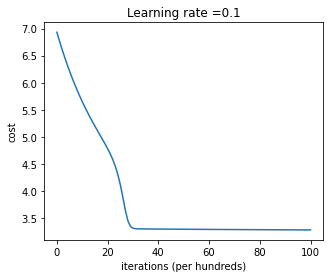

In [13]:
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(learning_rate))
#plt.yscale("log")
#plt.axis([0, len(costs), 0, 7])
plt.show()

In [17]:
print(parameters["b3"])

[[-0.90592108]
 [-0.64732214]
 [-0.88869884]
 [-0.87865486]
 [-0.8183186 ]
 [-0.84230267]
 [-0.865349  ]
 [-0.786225  ]
 [-0.9554065 ]
 [-0.84387728]]


This next section is for the definition of the L_model_forward for testing (without caches)

In [23]:
def linear_forward_testing(A, W, b):
    Z = np.dot(W, A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))

    return Z


def linear_activation_forward_testing(A_prev, W, b, activation):

    if activation == "sigmoid":
        z = linear_forward_testing(A_prev, W, b)
        a = 1/(1+np.exp(-z))

    elif activation == "relu":
        z = linear_forward_testing(A_prev, W, b)
        a = np.maximum(0, z)

    assert (a.shape == (W.shape[0], A_prev.shape[1]))

    return a


def L_model_forward_testing(x, parameters, outputs):

    a = x
    L = len(parameters) // 2  # number of layers in the neural network

    for l in range(1, L):
        a_prev = a
        a = linear_activation_forward_testing(a_prev, parameters['W' + str(l)], parameters['b' + str(l)],
                                             activation='relu')

    al = linear_activation_forward_testing(a, parameters['W' + str(L)], parameters['b' + str(L)], activation='sigmoid')

    assert (al.shape == (outputs, x.shape[1]))

    return al

In [24]:
def testing(X, Y, parameters, layers_dims):
    total = 0
    AL = L_model_forward_testing(X, parameters, layers_dims[-1])
    AL = AL.T
    Y = Y.T
    for i in range(0, Y.shape[0]):

        if np.where(Y[i] == np.max(Y[0]))[0][0] == np.where(AL[0] == np.max(AL[0]))[0][0]:
            total += 1
    return total/Y.shape[0]

value = testing(train_data, train_labels, parameters, layers_dims)
print("Efficiency with train_data " + str(value))
value = testing(test_data, test_labels, parameters, layers_dims)
print("Efficiency with test_data " + str(value))

Efficiency with train_data 0.09751666666666667
Efficiency with test_data 0.0974
